*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.0.2

torch: 2.6.0+cu126



# Model Zoo -- ResNet-34 MNIST Digits Classifier

### Network Architecture

The network in this notebook is an implementation of the ResNet-34 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  
本笔记本中的网络是基于MNIST数字数据集（http://yann.lecun.com/exdb/mnist/）实现的ResNet-34 [1]架构，用于训练手写数字分类器。

References  
参考文献

- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))  
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). 深度残差学习用于图像识别。在IEEE计算机视觉与模式识别会议论文集（第770-778页）。([CVPR 链接](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] http://yann.lecun.com/exdb/mnist/  
- [2] http://yann.lecun.com/exdb/mnist/

![](../images/resnets/resnet34/resnet34-arch.png)

The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.  
下图展示了带有跳跃连接的残差块，使得通过快捷方式传递的输入与主路径输出的维度相匹配，从而使网络能够学习恒等函数。

![](../images/resnets/resnet-ex-1-1.png)

The ResNet-34 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:  
ResNet-34架构实际上使用带有跳跃连接的残差块，使得通过快捷方式传递的输入被调整为与主路径输出的维度匹配。下图展示了这样的残差块：

![](../images/resnets/resnet-ex-1-2.png)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.set_per_process_memory_fraction(0.5, device=0)

## Model Settings

In [3]:
##########################
### 设置
##########################

# 超参数
RANDOM_SEED = 1  # 随机种子，用于确保实验结果可复现
LEARNING_RATE = 0.001  # 学习率
BATCH_SIZE = 128  # 批次大小
NUM_EPOCHS = 10  # 训练的总轮数

# 网络架构
NUM_FEATURES = 28*28  # 输入特征数（假设输入图像大小为28x28）
NUM_CLASSES = 10  # 分类数目（例如，手写数字分类任务中的0-9，共10类）

# 其他设置
DEVICE = "cuda:0"  # 指定使用的设备，这里选择第三个GPU（cuda:0）
GRAYSCALE = True  # 是否使用灰度图像（True表示使用灰度图像，False表示使用RGB图像）

### MNIST Dataset

In [4]:
##########################
### MNIST 数据集
##########################

# 注意 transforms.ToTensor() 会将输入图像缩放到 0-1 范围
train_dataset = datasets.MNIST(root='data', 
                               train=True,  # 训练集
                               transform=transforms.ToTensor(),  # 转换为Tensor格式
                               download=True)  # 如果数据集不存在，下载数据集

test_dataset = datasets.MNIST(root='data', 
                              train=False,  # 测试集
                              transform=transforms.ToTensor())  # 转换为Tensor格式


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,  # 设置批量大小
                          shuffle=True)  # 是否打乱数据

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,  # 设置批量大小
                         shuffle=False)  # 不打乱测试数据

# 检查数据集
for images, labels in train_loader:  # 遍历训练数据加载器中的每个batch  
    print('图像批次维度:', images.shape)  # 打印图像的维度
    print('图像标签维度:', labels.shape)  # 打印标签的维度
    break  # 只打印一次数据维度，避免浪费计算资源

图像批次维度: torch.Size([128, 1, 28, 28])
图像标签维度: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [6]:
##########################
### 模型
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3卷积，带填充"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # 第一层卷积层
        self.conv1 = conv3x3(inplanes, planes, stride)
        # 第一层BatchNorm层
        self.bn1 = nn.BatchNorm2d(planes)
        # 激活函数ReLU
        self.relu = nn.ReLU(inplace=True)
        # 第二层卷积层
        self.conv2 = conv3x3(planes, planes)
        # 第二层BatchNorm层
        self.bn2 = nn.BatchNorm2d(planes)
        # 下采样层（如果有的话）
        self.downsample = downsample
        # 步幅
        self.stride = stride

    def forward(self, x):
        residual = x

        # 经过第一层卷积、BatchNorm和ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 经过第二层卷积和BatchNorm
        out = self.conv2(out)
        out = self.bn2(out)

        # 如果有下采样，修改残差
        if self.downsample is not None:
            residual = self.downsample(x)

        # 残差连接
        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        # 判断是否为灰度图像
        if grayscale:
            in_dim = 1  # 灰度图像通道数为1
        else:
            in_dim = 3  # RGB图像通道数为3
        super(ResNet, self).__init__()
        # 第一层卷积，7x7的卷积核
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        # 第一层BatchNorm层
        self.bn1 = nn.BatchNorm2d(64)
        # 激活函数ReLU
        self.relu = nn.ReLU(inplace=True)
        # 最大池化层
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 第一个残差块
        self.layer1 = self._make_layer(block, 64, layers[0])
        # 第二个残差块
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # 第三个残差块
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # 第四个残差块
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # 平均池化层（为了做分类而做的池化）
        self.avgpool = nn.AvgPool2d(7, stride=1)
        # 全连接层
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 初始化网络参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # 判断是否需要下采样
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        # 添加第一个block
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        # 添加后续的block
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 第一层卷积
        x = self.conv1(x)
        # 第一层BatchNorm
        x = self.bn1(x)
        # 激活函数ReLU
        x = self.relu(x)
        # 最大池化
        x = self.maxpool(x)

        # 通过四个残差层
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # MNIST数据集已经是1x1的图像，可以跳过平均池化
        # x = self.avgpool(x)
        
        # 展平处理，传入全连接层
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        # 计算预测的概率分布
        probas = F.softmax(logits, dim=1)
        return logits, probas


def resnet34(num_classes):
    """构建ResNet-34模型"""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=True)  # 默认非灰度图像
    return model


In [7]:
torch.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [8]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0  # 初始化正确预测的数量和总样本数
    for i, (features, targets) in enumerate(data_loader):  # 遍历数据加载器中的每个批次
        features = features.to(device)  # 将特征移到指定设备
        targets = targets.to(device)  # 将标签移到指定设备

        logits, probas = model(features)  # 前向传播，得到logits和预测概率
        _, predicted_labels = torch.max(probas, 1)  # 获取概率最大的类别
        num_examples += targets.size(0)  # 增加批次中的样本数
        correct_pred += (predicted_labels == targets).sum()  # 计算正确预测的数量
    # 返回准确率（百分比），使用float()转换为浮点数
    return correct_pred.float()/num_examples * 100  


start_time = time.time()  # 记录训练开始时间
for epoch in range(NUM_EPOCHS):  # 遍历所有训练轮次
    
    model.train()  # 设置模型为训练模式
    for batch_idx, (features, targets) in enumerate(train_loader):  # 遍历训练数据
        features = features.to(DEVICE)  # 将特征移到指定设备
        targets = targets.to(DEVICE)  # 将标签移到指定设备
            
        ### 正向传播和反向传播
        logits, probas = model(features)  # 前向传播，得到logits和预测概率
        cost = F.cross_entropy(logits, targets)  # 计算交叉熵损失
        optimizer.zero_grad()  # 清空之前的梯度
        
        cost.backward()  # 反向传播，计算梯度
        
        ### 更新模型参数
        optimizer.step()  # 更新模型参数
        
        ### 记录日志
        if not batch_idx % 50:  # 每50个批次打印一次日志
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    # 设置模型为评估模式，以防在推理过程中更新批归一化参数
    model.eval()  
    with torch.set_grad_enabled(False):  # 在推理过程中禁用梯度计算，节省内存
        # 打印训练集上的准确率
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))  

    # 打印已用时间，单位：分钟
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))  
    
# 打印总训练时间，单位：分钟
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))  


Epoch: 001/010 | Batch 0000/0469 | Cost: 2.5540
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.2696
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.1280
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.0498
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.1965
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.0673
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.0767
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.0612
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.0386
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.1125
Epoch: 001/010 | Train: 97.845%
Time elapsed: 0.19 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0290
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0456
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0969
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0422
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0439
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0133
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0454
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0352
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0623
Epoch: 002/010 | Batch 0450/0469 

## Evaluation

In [9]:
with torch.set_grad_enabled(False): # 在推理过程中禁用梯度计算，节省内存
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.92%


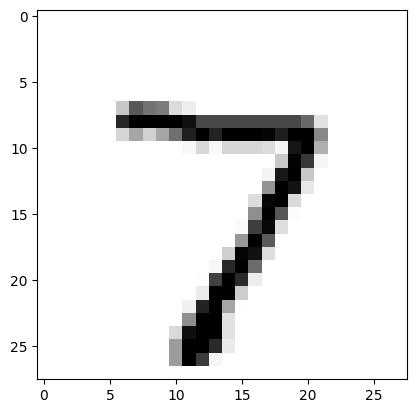

In [10]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [11]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


In [12]:
%watermark -iv

torch      : 2.6.0+cu126
numpy      : 1.26.4
matplotlib : 3.10.1
pandas     : 2.2.3
PIL        : 11.1.0
torchvision: 0.21.0+cu126

